In [1]:
import sys
import time
import copy

from itertools import repeat
import data, data.gene_datasets
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np
import matplotlib, matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import gene_inference
#from gene_inference.infer_genes import infer_all_genes, sample_neighbors
import models, models.graphLayer
from models.models import CGN
import data, data.gene_datasets
from data.graph import Graph
from data.utils import split_dataset
import optimization
import torch
from torch.autograd import Variable
from analysis.metrics import record_metrics_for_epoch
import analysis
reload(analysis.metrics)
reload(gene_inference);

In [2]:
#tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')
tcgatissue = data.gene_datasets.TCGATissue()

Converting one-hot labels to integers


In [3]:
class Object(object):
    pass

opt = Object()
opt.seed = 0
opt.nb_class = None
opt.nb_examples = None
opt.nb_nodes = None
opt.graph = "pathway"
opt.dataset = tcgatissue
opt.add_self = True
opt.norm_adj = True
opt.add_connectivity = False
opt.num_layer = 1
opt.cuda = True
opt.pool_graph = "ignore"


In [4]:
graph = Graph()
path = "/data/lisa/data/genomics/graph/pancan-tissue-graph.hdf5"
graph.load_graph(path)
#graph.intersection_with(tcgatissue)
g = nx.from_numpy_matrix(graph.adj)
mapping = dict(zip(range(0, len(tcgatissue.df.columns)), tcgatissue.df.columns))
g = nx.relabel_nodes(g, mapping)

In [6]:
def sample_neighbors(g, gene, num_neighbors, include_self=True):
    results = set([])
    if include_self:
        results = set([gene])
    all_nodes = set(g.nodes)
    first_degree = set(g.neighbors(gene))
    second_degree = set()
    for x in g.neighbors(gene):
        second_degree = second_degree.union(set(g.neighbors(x)))
    while len(results) < num_neighbors:
        if len(first_degree) - len(results) > 0:
            unique = first_degree - results
            results.add(np.random.choice(list(unique)))
        elif len(second_degree) - len(results) > 0:
            unique = second_degree - results
            results.add(np.random.choice(list(unique)))
        else:
            unique = all_nodes - results
            results.add(np.random.choice(list(unique)))
    return results

In [7]:
#sample_neighbors(g, "RPL5", 5, include_self=False)

In [8]:
import sklearn, sklearn.model_selection, sklearn.metrics, sklearn.linear_model, sklearn.neural_network, sklearn.tree
import numpy as np

class Method:
    def __init__(self):
        pass

class SkLearn(Method):
    
    def __init__(self, model, penalty=False):
        self.model = model
        self.penalty = penalty
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
        
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)

        if self.model == "LR":
            model = sklearn.linear_model.LogisticRegression()
            if self.penalty:
                model = sklearn.linear_model.LogisticRegression(penalty='l1', tol=0.0001)
        elif self.model == "DT":
            model = sklearn.tree.DecisionTreeClassifier()
        elif self.model == "MLP":
            model = sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(32,3), learning_rate_init=0.001, early_stopping=False,  max_iter=1000)
        else:
            print "incorrect label"
        
        model = model.fit(X_train, y_train)
        return sklearn.metrics.roc_auc_score(y_test, model.predict(X_test))


class PyTorch(Method):    
    
    def __init__(self, model, num_epochs=100, num_channel=64, num_layer=3, add_emb=32, use_gate=False, dropout=True, cuda=True):
        self.model = model
        self.batch_size = 10
        self.num_channel = num_channel
        self.num_layer = num_layer
        self.add_emb = add_emb
        self.use_gate = use_gate
        self.dropout = dropout
        self.cuda = cuda
        self.num_epochs = num_epochs
        
    def loop(self, dataset, seed, train_size, test_size, adj=None):
    
        X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(dataset.df, dataset.labels, stratify=dataset.labels, train_size=train_size, test_size=test_size, random_state=seed)
    
        #split train into valid and train
        local_X_train, local_X_valid, local_y_train, local_y_valid = sklearn.model_selection.train_test_split(X_train, y_train, stratify=y_train, train_size=0.60, random_state=seed)
    
    
        local_X_train = torch.FloatTensor(np.expand_dims(local_X_train, axis=2))
        local_X_valid = torch.FloatTensor(np.expand_dims(local_X_valid, axis=2))
        X_test = torch.FloatTensor(np.expand_dims(X_test, axis=2))
        
        local_y_train = torch.FloatTensor(local_y_train)

        criterion = optimization.get_criterion(dataset)
        
        patience = 20
        opt.num_layer = self.num_layer
        adj_transform, aggregate_function = models.graphLayer.get_transform(opt, adj)
        model = models.models.CGN(
                nb_nodes=len(dataset.df.columns), 
                input_dim=1,
                channels=[self.num_channel] * self.num_layer,
                adj=adj,
                out_dim=2,
                on_cuda=self.cuda,
                add_emb=self.add_emb,
                transform_adj=adj_transform,
                aggregate_adj=aggregate_function,
                use_gate=self.use_gate,
                dropout=self.dropout,
                )
        if self.cuda:
            torch.cuda.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)
            model.cuda()

        optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)
        max_valid = 0
        for t in range(0, self.num_epochs):
            start_timer = time.time()
            
            if self.cuda:
                model.cuda()
                model.on_cuda = True
            
            for base_x in range(0,local_X_train.shape[0], self.batch_size):
                inputs, labels = local_X_train[base_x:base_x+self.batch_size], local_y_train[base_x:base_x+self.batch_size]

                inputs = Variable(inputs, requires_grad=False).float()
                if self.cuda:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                model.train()
                y_pred = model(inputs)

                # Compute and print loss
                crit_loss = optimization.compute_loss(criterion, y_pred, labels)
                total_loss = crit_loss

                # Zero gradients, perform a backward pass, and update the weights.
                optimizer.zero_grad()
                crit_loss.backward()
                optimizer.step()
                model.eval()
            time_this_epoch = time.time() - start_timer
            
            
            auc = {}
            if self.cuda:
                model.cpu()
                model.on_cuda = False

            auc['train'] = sklearn.metrics.roc_auc_score(local_y_train.numpy(), model(Variable(local_X_train.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            auc['valid'] = sklearn.metrics.roc_auc_score(local_y_valid, model(Variable(local_X_valid.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            auc['test'] = sklearn.metrics.roc_auc_score(y_test, model(Variable(X_test.cpu(), requires_grad=False).float())[:,1].cpu().data.numpy())
            
            summary = [ t, crit_loss.data[0], auc['train'], auc['valid'], time_this_epoch ]
            summary = "epoch {}, cross_loss: {:.03f}, auc_train: {:0.3f}, auc_valid:{:0.3f}, time: {:.02f} sec".format(*summary)
            print summary

            patience = patience - 1
            if patience == 0:
                break
            if max_valid < auc['valid']:
                max_valid = auc['valid']
            if max_valid > auc['valid'] and t > 15:
                #scores.append(auc['test']) 
                return auc['test']
                break

In [9]:
def method_comparison(results, dataset, models, gene, max_genes, trials, train_size, test_size):
    
    dataset = data.gene_datasets.TCGATissue()
    dataset.df = dataset.df - dataset.df.mean()
    
    mean = dataset.df[gene].mean()
    dataset.labels = [1 if x > mean else 0 for x in dataset.df[gene]]
    full_df = dataset.df.copy(deep=True)
    
    print "Max ex ", int(np.log2(max_genes))+1
    for ex in range(4, int(np.log2(max_genes))+1):
        
        num_genes = 2**ex
        num_genes = np.min([num_genes, tcgatissue.df.shape[1]])
        print ex, num_genes
        
        neighbors = sample_neighbors(g, gene, num_genes, include_self=False)
        print "neighbors", len(neighbors)
        
        if gene in neighbors:
            neighbors.remove(gene)

        dataset.df = dataset.df[list(neighbors)]
        dataset.data = dataset.df.as_matrix()
        
        neighborhood = np.asarray(nx.to_numpy_matrix(nx.Graph(g.subgraph(neighbors))))
        
        for model in models:
            for seed in range(trials):
            
                #have we already done it?
                already_done = results["df"][(results["df"].gene_name == gene) & 
                                             (results["df"].model == model['key']) &
                                             (results["df"].num_genes == num_genes) &
                                             (results["df"].seed == seed) &
                                             (results["df"].train_size == train_size)].shape[0] > 0

                if already_done:
                    print "already done:", model['key'], num_genes, seed
                    continue
                print "doing:", model['key'], num_genes, seed

                result = model['method'].loop(dataset=dataset, seed=seed, train_size=train_size, test_size=test_size, adj=neighborhood)

                experiment = {"gene_name": gene,
                        "model": model['key'],
                        "num_genes": num_genes, 
                        "seed":seed,
                        "train_size": train_size,
                        "auc":result
                        }

                results["df"] = results["df"].append(experiment, ignore_index=True)
                pickle.dump(results, open("results-temp.pkl", "wb"))
        dataset.df = full_df
    

In [24]:
import data
reload(data)
#reload(models.models)
reload(gene_inference)
#reload(gene_inference.models)
reload(analysis.metrics)
import pickle

m = [
    {'key': 'LR-L1', 'method': SkLearn("LR", penalty=True)},
#    {'key': 'MLP', 'method': mlp},
    {'key': 'DT', 'method': SkLearn("DT")},
   {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': PyTorch("CGN")},
    ]



In [26]:
#results = {"df": pd.DataFrame(columns=['auc','gene_name', 'model', 'num_genes', 'seed', 'train_size'])}

In [27]:
#results = pickle.load(open("results-temp.pkl", "r"))

In [28]:
method_comparison(results, tcgatissue, m, gene="RPL5", max_genes=600, trials=1, train_size=100, test_size=1000)

Converting one-hot labels to integers
Max ex  10
4 16
neighbors 16
already done: LR-L1 16 0
already done: DT 16 0
doing: CGN_3_layer_64_channel_emb_32_dropout 16 0


/u/cohenjos/.local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


Doing drop-out
epoch 0, cross_loss: 0.683, auc_train: 0.731, auc_valid:0.690, time: 4.13 sec
epoch 1, cross_loss: 0.697, auc_train: 0.853, auc_valid:0.770, time: 0.04 sec
epoch 2, cross_loss: 0.729, auc_train: 0.895, auc_valid:0.795, time: 0.03 sec
epoch 3, cross_loss: 0.716, auc_train: 0.907, auc_valid:0.798, time: 0.03 sec
epoch 4, cross_loss: 0.690, auc_train: 0.923, auc_valid:0.797, time: 0.03 sec
epoch 5, cross_loss: 0.684, auc_train: 0.932, auc_valid:0.807, time: 0.03 sec
epoch 6, cross_loss: 0.679, auc_train: 0.937, auc_valid:0.818, time: 0.03 sec
epoch 7, cross_loss: 0.680, auc_train: 0.938, auc_valid:0.810, time: 0.03 sec
epoch 8, cross_loss: 0.601, auc_train: 0.937, auc_valid:0.800, time: 0.03 sec
epoch 9, cross_loss: 0.578, auc_train: 0.935, auc_valid:0.788, time: 0.03 sec
epoch 10, cross_loss: 0.470, auc_train: 0.931, auc_valid:0.782, time: 0.03 sec
epoch 11, cross_loss: 0.382, auc_train: 0.934, auc_valid:0.780, time: 0.03 sec
epoch 12, cross_loss: 0.335, auc_train: 0.941, 

In [209]:
import pickle
#pickle.dump(results, open("results.pkl", "wb"))

In [10]:
results = pickle.load(open("results-temp.pkl", "r"))

In [25]:
results["df"]

,auc,gene_name,model,num_genes,seed,train_size
0,0.800461,RPL5,LR-L1,16,0,100
1,0.822363,RPL5,LR-L1,16,1,100
2,0.832213,RPL5,LR-L1,16,2,100
3,0.731107,RPL5,DT,16,0,100
4,0.760795,RPL5,DT,16,1,100
5,0.801509,RPL5,DT,16,2,100
6,0.773086,RPL5,LR-L1,32,0,100
7,0.812424,RPL5,LR-L1,32,1,100
8,0.816969,RPL5,LR-L1,32,2,100
9,0.735812,RPL5,DT,32,0,100


In [20]:
grouped = results["df"].groupby(['gene_name', 'model','num_genes'])['auc'].agg(['mean','std', 'count'])
grouped

mean       std  count
gene_name model num_genes                           
RPL5      DT    16         0.760771  0.025832      5
                32         0.773893  0.023490      5
                64         0.778796  0.033080      5
                128        0.775419  0.026961      5
                256        0.782436  0.034340      5
                512        0.796946  0.013723      5
          LR-L1 16         0.815425  0.014253      5
                32         0.813424  0.025651      5
                64         0.837464  0.012902      5
                128        0.822951  0.015170      5
                256        0.833170  0.013815      5
                512        0.812256  0.027872      5

In [21]:
#results["df"].groupby(['gene_name', 'model','num_genes'])['auc'].mean().groupby(["model"]).plot(legend=True, sharex=True);

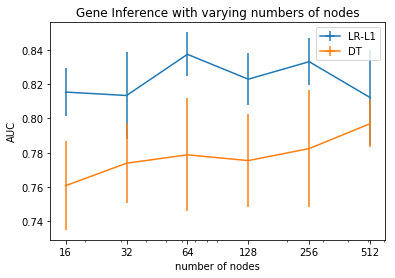

In [22]:
%matplotlib inline
for model in results["df"]["model"].unique():
    index = results["df"].groupby(['model','num_genes'])['auc'].mean()[model].index
    mean = results["df"].groupby(['model','num_genes'])['auc'].mean()[model]
    stderr = results["df"].groupby(['model','num_genes'])['auc'].std()[model]
    plt.errorbar(index, mean,label=model, xerr=0, yerr=stderr)


plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.xscale("log")
plt.xticks(sorted(results["df"]["num_genes"].unique()))
formatter = matplotlib.ticker.ScalarFormatter()
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend();

In [ ]:
#results_df = pd.DataFrame(columns=['model', 'num_genes', 'gene_name', 'auc', 'std'])
#results_df = results_df.append(data=pd.DataFrame(pd.DataFrame(data={'model':"LR", 'num_genes': 10.0, 'gene_name': "RPL5", 'auc':0.57, 'std': 0.01}, index=[0]))
len(["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"])
len([10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0])
len([0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92])
len([0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00])
results_df = pd.DataFrame(data={'model':["LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout", "LR", "MLP", "Decision Tree", "CGN_3_layer_64_channel_emb_32_dropout"],
                   'num_genes': [10.0, 10.0, 10.0, 10.0, 510.0, 510.0, 510.0, 510.0, 1010.0, 1010.0, 1010.0, 1010.0, 1510.0, 1510.0, 1510.0, 1510.0, 2010.0, 2010.0, 2010.0, 2010.0, 2510.0, 2510.0, 2510.0, 2510.0, 3010.0, 3010.0, 3010.0, 3010.0],
#                  'gene_name': ["RPL5", "RPL5"],
                   'auc': [0.57, 0.56, 0.55, 0.64, 0.81, 0.83, .79, .94, .81, .80, .78, .94, .80, .74, .77, .93, .78, .79, .78, .92, .77, .77, .76, .92, .76, .71, .76, .92],
                   'std': [0.01, 0.04, 0.03, 0.01, 0.02, 0.01, 0.03, 0.00, 0.01, 0.03, 0.02, 0.01, 0.03, 0.12, 0.02, 0.00, 0.03, 0.02, 0.03, 0.01, 0.02, 0.05, 0.04, 0.01, 0.02 ,0.11, 0.02, 0.00]}, index=range(0, 28))
plt.figure()
titles = []
for model in [
    {'key': 'LR', 'method': lr},
    {'key': 'MLP', 'method': mlp},
    {'key': 'Decision Tree', 'method': decision_tree},
    {'key': 'CGN_3_layer_64_channel_emb_32_dropout', 'method': cgn_loop, 'num_channel': 64, 'num_layer': 3, 'add_emb': 32, 'use_gate': False, 'dropout': True, 'cuda': True},
    ]:
    temp_results = results_df.loc[results_df['model'] == model['key']].reset_index(drop=True)
    lines.append(plt.errorbar(temp_results.index, temp_results['auc'], xerr=0, yerr=temp_results['std'])[0])
    titles.append(model['key'])
    plt.xticks(list(temp_results.index), temp_results['num_genes'], rotation=70)
width = 0.2
plt.title("Inferring the value of RPL5 with varying numbers of genes")
plt.ylabel("AUC")
plt.xlabel("# genes")
plt.legend(lines, titles, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)


In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_genes'], rotation=70)
plt.title("Gene Inference with varying numbers of nodes")
plt.ylabel("AUC")
plt.xlabel("number of nodes")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)

In [ ]:
# Predict a gene from a growing number of Nodes
lr_results = pd.DataFrame([])
mlp_results = pd.DataFrame([])
cgn_results = pd.DataFrame([])
gene = "RPL5"
max_samples = 200
reload(data)
reload(models)
tcgatissue = data.gene_datasets.TCGATissue(data_dir='./genomics/TCGA/', data_file='TCGA_tissue_ppi.hdf5')

for num_samples in range(10, max_samples, 20):
    lr_row = infer_gene(lr, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    lr_results = lr_results.append(lr_row).reset_index(drop=True)
    lr_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    cgn_row = infer_gene(cgn, tcgatissue, "RPL5", train_size=num_samples, test_size=200, trials=3, penalty=True)
    cgn_results = cgn_results.append(cgn_row).reset_index(drop=True)
    cgn_results.loc[lr_results.index[-1], 'num_samples'] = num_samples
    print num_genes
    print cgn_results
    print lr_results

In [ ]:
# results of adding Nodes
plt.figure()

#full_results.loc[full_results['samples'] == 100]

line1 = plt.errorbar(lr_results.index, lr_results['auc'], xerr=0, yerr=lr_results['std'])
line2 = plt.errorbar(cgn_results.index, cgn_results['auc'], xerr=0, yerr=cgn_results['std'])

width = 0.2
plt.xticks(list(lr_results.iloc[::5, :].index), lr_results.iloc[::5, :]['num_samples'], rotation=70)
plt.title("Gene Inference with varying numbers of samples")
plt.ylabel("AUC")
plt.xlabel("number of samples")
plt.legend((line1[0], line2[0]), ('LR', "CGN"), bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., fontsize=10)